In [2]:
### in this file, we experiment with feature extraction

%pylab inline
%load_ext autoreload
%autoreload 2

import os
import sys
sys.argv=['']
sys.path.append('/nethome/jbang36/eva_jaeho')



import numpy as np
#import utils.helpers as helpers
import utils as helpers
from loaders.uadetrac_loader import UADetracLoader
from eva_storage.preprocessingModule import PreprocessingModule
from eva_storage.UNet import UNet
from eva_storage.clusterModule import ClusterModule
from filters.minimum_filter import FilterMinimum

from loaders.seattle_loader import SeattleLoader
from eva_storage.sampling_experiments.sampling_utils import *
from eva_storage.analysis.sampling_analysis_tools import *
from eva_storage.featureExtractionMethods import *
from eva_storage.temporalClusterModule import *
from eva_storage.samplingMethods import *
from eva_storage.sampling_experiments.noscope_sample_ssd_evaluation import *
from loaders.pp_loader import PPLoader

import cv2

Populating the interactive namespace from numpy and matplotlib


## First, we compute the distance matrix for original image / semantic features (vgg16) / and downsampled images

In [3]:
loader = SeattleLoader()
video_directory = '/nethome/jbang36/eva_jaeho/data/seattle/seattle2.mp4'
images = loader.load_images(video_directory)
images.shape

11-12-2020 16:16:52 [info:049]INFO : meta data of the video /nethome/jbang36/eva_jaeho/data/seattle/seattle2.mp4 is (168601, 240, 360, 3)
11-12-2020 16:17:44 [info:049]INFO : Loaded 168601 in 52.25120341498405 seconds


(168601, 240, 360, 3)

In [4]:
images = images[:10000]
### save on some memory...

#### Examine and derive characteristics and features of current vgg16 feature extraction method -- examine if there is a pattern we can work on

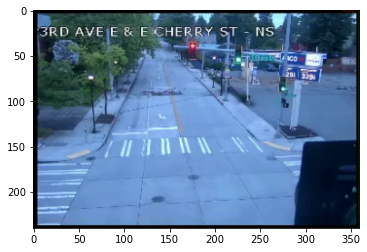

In [8]:
plt.imshow(images[0])

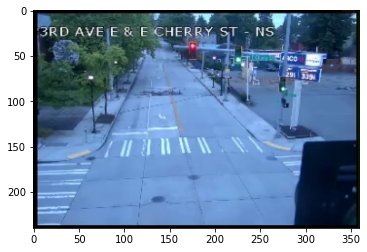

In [9]:
plt.imshow(images[1])

In [12]:
h,w,channels = images[0].shape
print(np.linalg.norm(images[0] - images[1]) / (h*w*channels))

0.059998921122670135


In [20]:
image0_d = images[0][::2,::2,:]
image1_d = images[1][::2,::2,:]
h,w,channels = image0_d.shape
print(np.linalg.norm(image0_d - image1_d) / (h*w*channels))
print(np.linalg.norm(image0_d - image1_d))

0.11804410599687101
7649.258068597242


In [5]:
toy_images = images[:1000]

In [6]:
### draw distance graph?
from sklearn.metrics import pairwise_distances
n,h,w,c = toy_images.shape
toy_images_flattened = np.reshape(toy_images, (n,-1))
original_distances = pairwise_distances(toy_images_flattened)


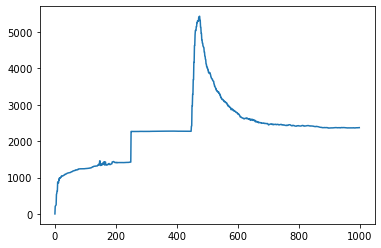

In [7]:
distance_from0 = original_distances[0]
plt.plot(distance_from0)

Displaying 2 rows


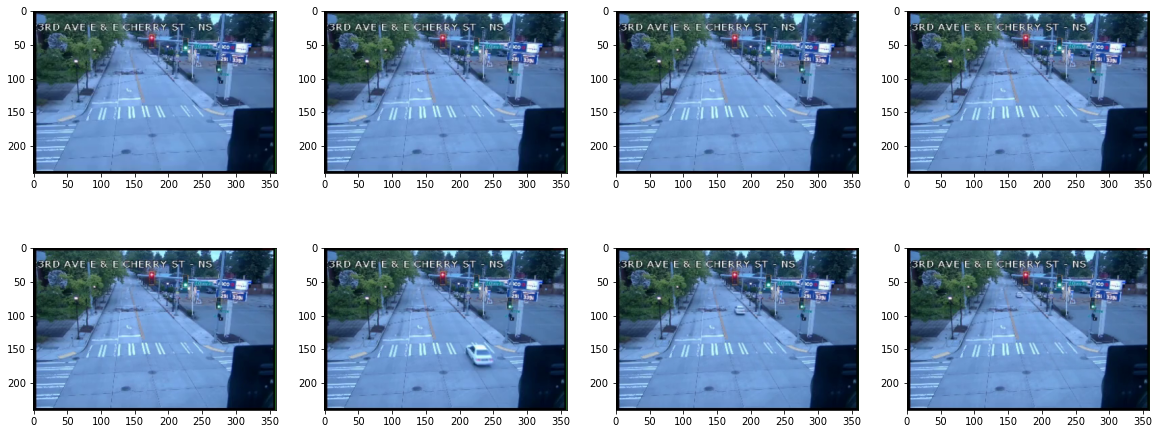

In [33]:
images_of_interest = [images[0], images[100], images[200], images[300], images[400], images[500], images[600], images[700]]
from miscellaneous_code import draw_multiple_images
draw_multiple_images(images_of_interest)

### start of vgg feature extraction

In [8]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True).cpu()

re_toy_images = []


for i in range(len(toy_images)):
    re_toy_images.append (cv2.resize(toy_images[i], (300,300)))

    
re_toy_images1 = np.stack(re_toy_images, axis = 0)
re_toy_images1.shape


digits_tensor = torch.tensor(re_toy_images1, device = 'cpu').float()
digits_tensor = digits_tensor.permute(0,3,1,2)
digits_tensor.size()


images_features = []


batch_size = 10
digits_tensor.size()


for i in range(0, len(digits_tensor), batch_size):
    result = vgg16.features(digits_tensor[i:i+batch_size])
    ## need to convert
    result = result.detach().permute(0,2,3,1).numpy()
    images_features.append(result)


In [10]:
image_features = np.stack(images_features, axis = 0)
image_features.shape

(100, 10, 9, 9, 512)

In [12]:
vgg_features_flattened = image_features.reshape(1000, -1)
vgg_distances = pairwise_distances(vgg_features_flattened)

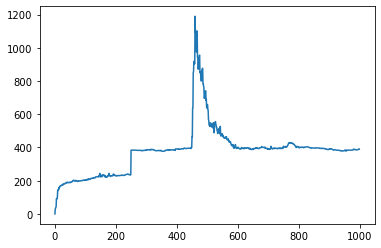

In [13]:
vgg_distance_from0 = vgg_distances[0]
plt.plot(vgg_distance_from0)

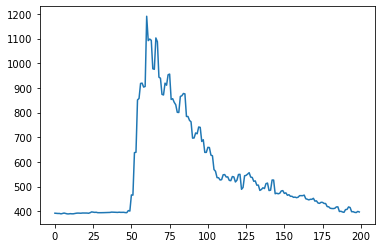

In [14]:
vgg400_600 = vgg_distance_from0[400:600]
plt.plot(vgg400_600)

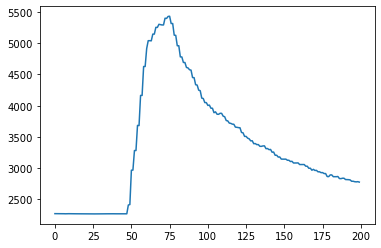

In [15]:
##comparison aginast original
distance_from0 = original_distances[0]
distance400_600  = distance_from0[400:600]
plt.plot(distance400_600)

In [ ]:
### just from looking at these images, we arrive at two conclusions:
### 1. vgg16 is a deterministic network -- if given the same image, it spits out the same output
### 2. the features are no smooth --gradual change in motion doesn't necessarily mean there will be a gradual change in the features that are extracted

### is point number 2 important, how could we achieve smoothness??

In [ ]:
### TODO: we need to look at fuzzy lines -- understand why they are much more fuzzier than the original image...
### we need to understand why most of the channels are pitch black, there could be room for further development such as... (using less parameters, making the images more representable... etc)

In [ ]:
##### end of vggg

In [ ]:
#### I want to futher investigate this trend...
### It seems just from visualization of the graph that a sharp increase then monotonic decrease means a car is moving further away
### It is easy to divide the blocks of video into portions, we just have to check the derivative of this function

### the systematic method will be
"""
1. compute the derivative.
2. measure the """

In [34]:
images_downsampled = images[:,::24,::36,:]


In [35]:
n,h,w,c = images_downsampled.shape
images_downsampled_flattened = images_downsampled.reshape(n,-1)
print(images_downsampled_flattened.shape)
original_distances = pairwise_distances(images_downsampled_flattened)

(168601, 300)


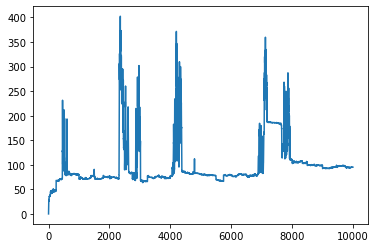

In [37]:
distance_from0 = original_distances[0][:10000]
plt.plot(distance_from0)

In [1]:
### let's increase the size of the plot
print('hello world')

hello world


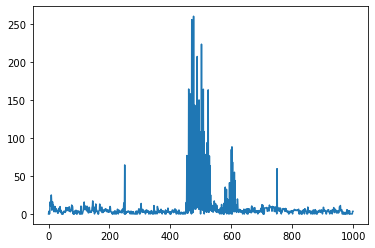

In [39]:
### distance between itself and the frame before it
derivative = [0]
for i in range(10000):
    derivative.append(original_distances[i+1][i])
plt.plot(derivative[:1000])

In [41]:
### how to find the appropriate threshold???
median = np.median(derivative)
## count how many points are above this median
above_median_points = []
for i in range(len(derivative)):
    if derivative[i] > median:
        above_median_points.append(i)
        
print(len(above_median_points))

4960


In [42]:
len(derivative)

10001

In [ ]:
## TODOS, we need to try this on various types of datasets, for example, what happens when we have a video with multiple cars?


In [28]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True).cpu()

re_toy_images = []


for i in range(len(toy_images)):
    re_toy_images.append (cv2.resize(toy_images[i], (300,300)))

    
re_toy_images1 = np.stack(re_toy_images, axis = 0)
re_toy_images1.shape


digits_tensor = torch.tensor(re_toy_images1, device = 'cpu').float()
digits_tensor = digits_tensor.permute(0,3,1,2)
digits_tensor.size()


images_features = []


batch_size = 10
digits_tensor.size()


for i in range(0, len(digits_tensor), batch_size):
    result = vgg16.features(digits_tensor[i:i+batch_size])
    ## need to convert
    result = result.detach().permute(0,2,3,1).numpy()
    images_features.append(result)


In [29]:
images_features = np.stack(images_features, axis = 0)
print(images_features.shape) ### 41472 number of features

images_features = np.reshape(images_features, (1000,9,9,512))
images_features = np.transpose(images_features, (0,3,1,2))

print(images_features.shape)

(100, 10, 9, 9, 512)
(1000, 512, 9, 9)


In [18]:
### determine the difference between first and second frame
features0 = images_features[0]
features1 = images_features[1]
channels, h, w, = features0.shape
print(np.linalg.norm(features0 - features1))



27.466656


#### Examining mean pooling vs vgg16 in terms of difference between original features

In [3]:
###

### let's take the first 1000 frames and compute the distance matrix

toy_images = images[:1000]


In [4]:
feature_format = toy_images.reshape(1000, -1)

In [5]:
from sklearn.metrics import pairwise_distances

distance_matrix = pairwise_distances(feature_format)

In [6]:
distance_matrix.shape

(1000, 1000)

In [11]:
print(distance_matrix.max())
print(distance_matrix.min())

6587.76274618326
0.0


In [41]:
downsampled_toy_images = images[:1000, ::2, ::2, :]  ## 300 features
downsampled_feature_format = downsampled_toy_images.reshape(1000, -1)

In [43]:
downsampled_feature_format.shape

(1000, 64800)

In [44]:
downsampled_distance_matrix = pairwise_distances(downsampled_feature_format)

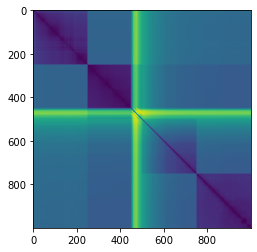

In [30]:
plt.imshow(distance_matrix)

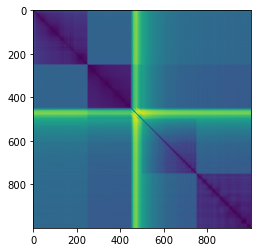

In [45]:
plt.imshow(downsampled_distance_matrix)

In [6]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True, device = 'cpu')



In [8]:
### toy images resize to 300x300
import cv2
re_toy_images = []

for i in range(len(toy_images)):
    re_toy_images.append (cv2.resize(toy_images[i], (300,300)))
    
re_toy_images1 = np.stack(re_toy_images, axis = 0)
re_toy_images1.shape

digits_tensor = torch.tensor(re_toy_images1).float().cpu()
digits_tensor = digits_tensor.permute(0,3,1,2)
digits_tensor.size()

images_features = []

batch_size = 10
digits_tensor.size()

for i in range(0, len(digits_tensor), batch_size):
    

    result = vgg16.features(digits_tensor[i:i+batch_size])
    ## need to convert
    result = result.detach().permute(0,2,3,1).numpy()
    images_features.append(result)

type(images_features[0])   

images_features = np.stack(images_features, axis = 0)
images_features.shape ### 41472 number of features

tmp = np.reshape(images_features, (1000, 9, 9, 512))
tmp.shape

torch.Size([1000, 3, 300, 300])

torch.Size([1000, 3, 300, 300])

torch.Tensor

(100, 10, 9, 9, 512)

(1000, 9, 9, 512)

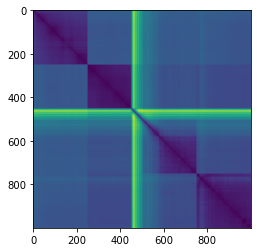

In [29]:
## now we need to compute the distance
vgg16_features = images_features.reshape(1000, -1)
vgg_distance_matrix = pairwise_distances(vgg16_features)
plt.imshow(vgg_distance_matrix)

In [46]:
#### after showing the distance matrix, we compute the l2 norm
dist_downsample = np.linalg.norm(distance_matrix - downsampled_distance_matrix)
dist_vgg = np.linalg.norm(distance_matrix - vgg_distance_matrix)
print(dist_downsample)
print(dist_vgg)

In [47]:
print(dist_downsample)
print(dist_vgg)

1239966.3778708915
2089070.6464508711


In [49]:
#### examine the content of vgg16_features
vgg16_features = images_features.reshape(1000, 9, 9, 512)
print(vgg16_features.shape)

(1000, 9, 9, 512)


In [50]:
from miscellaneous_code import *


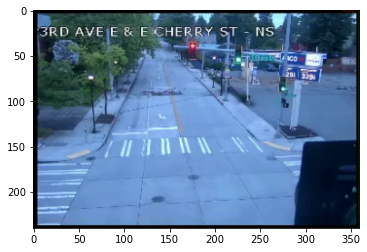

In [51]:
plt.imshow(images[0])

In [55]:
image0_features = vgg16_features[0]
print(image0_features.shape)
image0_features = np.transpose(image0_features, (2, 0,1))
image0_features.shape

(9, 9, 512)


(512, 9, 9)

In [1]:
print('ehhwlo world')

ehhwlo world


Displaying 100 rows


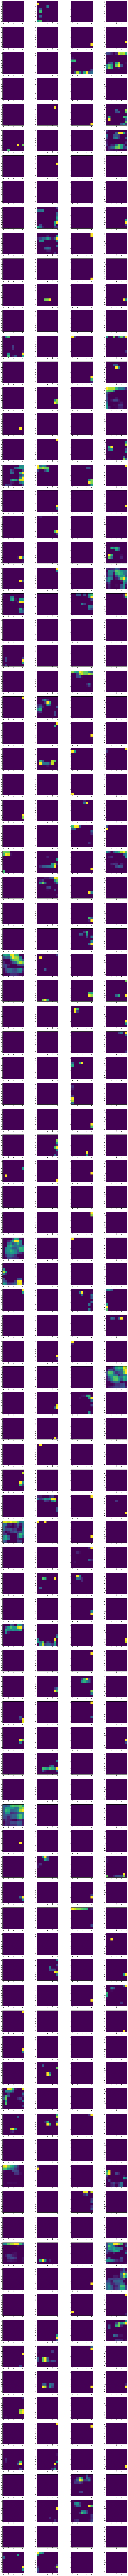

In [56]:


draw_multiple_images(image0_features)

In [118]:
###
a = np.array([1,2,3,4,5])
a = a.astype(np.int)

In [60]:
vgg16_features.shape

(1000, 9, 9, 512)

In [67]:
### what we need to do is see what the output of the solution set is
x = np.reshape(vgg16_features, (1000, -1))



In [97]:
_, solution_set_indices = fpf(x, 10)

In [98]:
labels = label_points(x, solution_set_indices)

In [99]:
solution_set_indices

array([659, 460, 475, 486, 454, 467, 498, 479, 471, 527])

In [100]:
len(labels)

1000

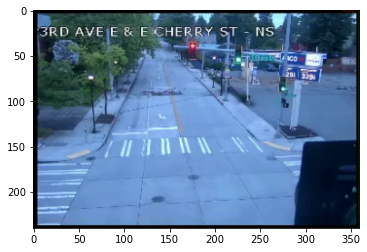

In [103]:
plt.imshow(images[0])

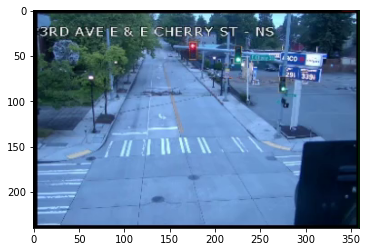

In [104]:
plt.imshow(images[1000])

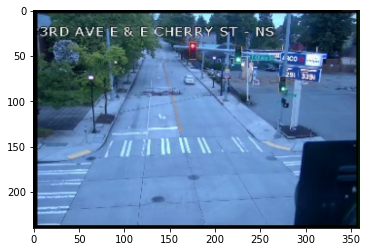

In [106]:
plt.imshow(images[659])

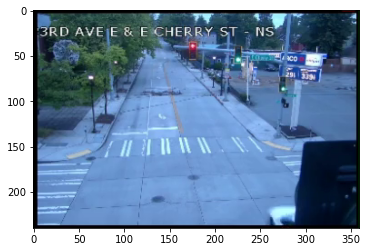

In [107]:
plt.imshow(images[454])

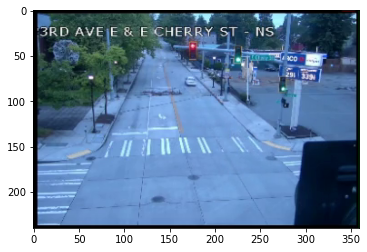

In [117]:
plt.imshow(images[650])

In [102]:
labels[:1000]

array([659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659,
       659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 659, 65

In [96]:
from sklearn.metrics import pairwise_distances

def label_points(points, solution_set_indices):
    ### what we need to do is, for each point, we need to select k number of representative frames
    ### to simply the approach, let's select 1 rep frame and label it as the same thing
    distance_matrix = pairwise_distances(points)
    labels = []
    
    for i in range(len(points)):
        my_distances = distance_matrix[i]
        my_key_distances = my_distances[solution_set_indices]
        my_choice_index = np.argmin(my_key_distances)
        my_choice_index_prop = solution_set_indices[my_choice_index]
        labels.append(my_choice_index_prop)
    return np.array(labels)
    
    



def fpf(points, k):
    solution_set_indices = []
    rand_int = random.randint(0, len(points))
    solution_set_indices.append(rand_int)
    distance_matrix = pairwise_distances(points)
    
    for _ in range(k - 1):
        relevant_distance_arrays = []
        for solution_index in solution_set_indices:
            relevant_distance_arrays.append(distance_matrix[solution_index])
        ## we find the minimum distances
        relevant_distance_arrays = np.array(relevant_distance_arrays)
        updated_distances = relevant_distance_arrays.min(axis = 0)
        #### we find the index of the maximum value and append to solution_set
        solution_set_indices.append(np.argmax(updated_distances))
    
    solution_set_indices = np.array(solution_set_indices)
    return points[solution_set_indices], solution_set_indices
            


### scrap code

In [ ]:
### maybe the size is too small?
tmp = np.ndarray(shape = (10, 3, 300,300))
tmp_tensor = torch.tensor(tmp).float().cuda()
tmp_result = vgg16.features(tmp_tensor)

In [23]:
print(tmp_tensor.size())
print(tmp_result.size())

torch.Size([10, 3, 300, 300])
torch.Size([10, 512, 9, 9])


In [20]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
##### 


